In [1]:

from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')



In [142]:
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile

df=pd.read_excel('Project_dataset.xlsx',sheet_name='Project_dataset',header=None)

#import sklearn package
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

#sperate training and test dataset
data=df.iloc[:,:]
#X_train, X_test=train_test_split(X,test_size=0.3,random_state=0)

from sklearn.preprocessing import StandardScaler ,scale
import numpy as np
import math
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')



# Analysis of normalized Data

In [143]:
#Standarize to (0,1)
#X=preprocessing.scale(data)
scaler = StandardScaler()
X = scaler.fit_transform(data)
#calculating covariance matrix
cov_mat=np.cov(X.T)

In [144]:
#calculating eigen_vals and eigen_vecs
eigen_vals, eigen_vecs=np.linalg.eig(cov_mat)


In [145]:
#variance explained ratios
tot=sum(eigen_vals) # sumation of eigen_value
var_exp=[(i/tot) for i in sorted(eigen_vals,reverse=True)] # ratio of each eigen_value
cum_var_exp=np.cumsum(var_exp)

## PCA 

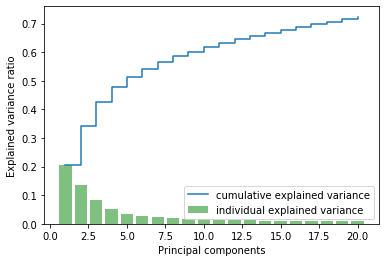

<Figure size 432x288 with 0 Axes>

In [146]:
#Pareto plot
import matplotlib.pyplot as plt
fig,ax =plt.subplots()
STEP =20
plt.bar(range(1,1+STEP),var_exp[0:STEP],alpha=0.5,color='green', label='individual explained variance')
plt.step(range(1,1+STEP), cum_var_exp[0:STEP], where='post',label='cumulative explained variance') 
#plt.axhline(y=0.8,color='r',linestyle='--')
plt.ylabel('Explained variance ratio') 
plt.xlabel('Principal components') 
plt.legend() 
plt.show()
plt.savefig("_images/pareto.png")

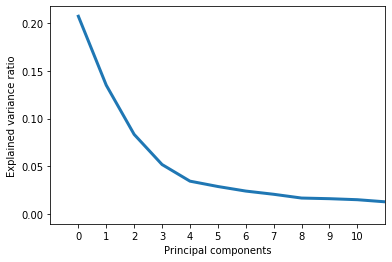

<Figure size 432x288 with 0 Axes>

In [147]:
#Scree plot
#plt.plot(range(len(eigen_vals)),sorted(eigen_vals,reverse=True),lw=3)
plt.plot(range(len(eigen_vals)),var_exp,lw=3)
#plt.plot([-1,8],[eigen_vals[7],eigen_vals[7]],'g--')
#plt.plot([8,8],[-5,eigen_vals[7]],'g--')
plt.xlim(-1,11)

plt.xticks(np.linspace(0,10,11))
plt.ylabel('Explained variance ratio') 
plt.xlabel('Principal components')
plt.show()
plt.savefig("_images/scree.png")

##### According to above charts we chose 10 PCs to apply following analysis

In [148]:
# Determine number of PC
from sklearn.decomposition import PCA
from scipy.stats import chi2
pca_num=8
alpha=0.0027
pca=PCA(n_components=pca_num) # chose 20 PCs for following analysis
X_pca=pca.fit_transform(X)
X_pca.shape
# chi square critical value
UCL=chi2.isf(alpha,len(X_pca[0,:]))


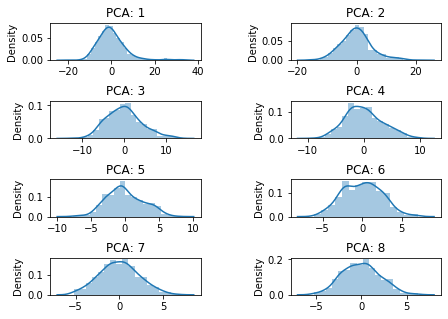

<Figure size 432x288 with 0 Axes>

In [149]:
# check whether each row of data follows normal distribution 
fig,ax = plt.subplots(figsize=(7,5))
plt.subplots_adjust(wspace=0.6,hspace=1.1,)
for i in range(len(X_pca[1,:])):
    nrow=math.ceil(len(X_pca[1,:])/2)
    ncol=2
    plt.subplot(nrow,ncol,i+1)
    sns.distplot(X_pca[:,i],label='PC'+str(i+1))
    plt.title("PCA: {}".format(i+1))
plt.show()
plt.savefig("_images/before.png")

In [150]:
from scipy.stats import jarque_bera
from scipy.stats import probplot
for i in range(len(X_pca[1,:])):
               print(jarque_bera(X_pca[:,i])[1])


0.0
1.8876722407412672e-10
0.0011875405448327214
0.004764137663120005
0.03167423716229811
0.06956628968689982
0.2591853731296563
0.16926114994779762


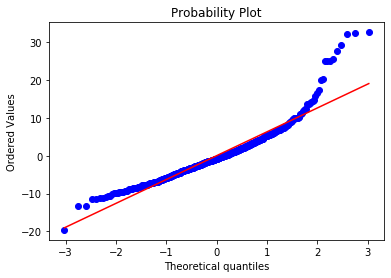

In [75]:
res = probplot(X_pca[:,0],plot=plt)

In [76]:
def mT_square(inputdata,alpha=0.05):
    "input data and calculate the T sqaure statistic, if there have outlier in the result then remove off"
    # covariance matrix of trimmed dataset
    cov_mat=np.cov(inputdata.T)
    cov_mat_inv=np.linalg.inv(cov_mat)
    X_bar=[inputdata[:,i].mean() for i in range(len(inputdata[0,:]))]
    # calculating X_-X_bar
    X_sub=[inputdata[i,:]-X_bar for i in range(len(inputdata))]
    X_sub=np.asmatrix(X_sub)
    # calculating T^2 statistics
    T_square=[np.float(np.matmul(np.matmul(X_sub[i,:],cov_mat_inv),X_sub[i,:].T)) for i in range(len(X_sub))]
    return np.asarray(T_square)

##### UCL setting  (Cynthia A. Lowry, William H. Woodall, Charles W. Champ, &amp; Steven E. Rigdon, 1992)
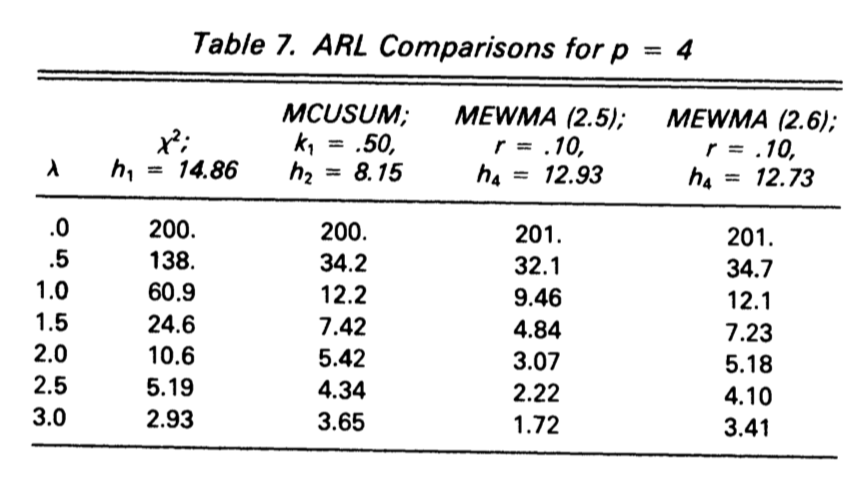

In [77]:
def mCUSUM(inputdata,k):
    CUSUM_mc=np.zeros(len(inputdata),dtype=float)
    CUSUM_n=np.ones(len(inputdata))
    CUSUM_k=k # detecting statistical distance of mean shift
    # covariance matrix of trimmed dataset
    cov_mat=np.cov(inputdata.T)
    cov_mat_inv=np.linalg.inv(cov_mat)
    X_bar=[inputdata[:,i].mean() for i in range(len(inputdata[0,:]))]
    # calculating X_-X_bar
    X_sub=inputdata-X_bar
    X_sub=np.asmatrix(X_sub)
    #initial cond.
    CUSUM_c=inputdata[0,:]-X_bar
    CUSUM_mc[0]=max(0.0,math.sqrt(np.matmul(np.matmul(CUSUM_c,cov_mat_inv),CUSUM_c.T))-CUSUM_k*CUSUM_n[0])
    #iteration
    for i in range(1,len(inputdata)):
        if (CUSUM_mc[i-1]!=0.0):
            CUSUM_n[i]=CUSUM_n[i-1]+1
        CUSUM_c=sum(inputdata[(i-int(CUSUM_n[i])+1):i+1]-X_bar)
        
        CUSUM_mc[i]=max(0.0,math.sqrt(np.matmul(np.matmul(CUSUM_c,cov_mat_inv),CUSUM_c.T))-CUSUM_k*CUSUM_n[i])
    
    return np.asarray(CUSUM_mc)

In [78]:
def mEWMA(inputdata,r):
    # mewma
    #covariance matrix of trimmed dataset
    cov_mat=np.cov(inputdata.T)
    cov_mat_inv=np.linalg.inv(cov_mat)
    X_bar=[inputdata[:,i].mean() for i in range(len(inputdata[0,:]))]
    mewma_lamda=r
    mewma_z=np.zeros((len(inputdata),len(inputdata[0,:])))
    mewma_z[0,:]=X_bar
    UCL=chi2.isf(alpha,pca_num)
    # Giving value to z
    for i in range(1,len(inputdata)):
        mewma_z[i,:]=mewma_lamda*inputdata[i,:]+(1-mewma_lamda)*mewma_z[(i-1),:]
    # cov of z
    cov_z=np.cov(mewma_z.T)
    cov_z_inv=np.linalg.inv(cov_z)
    # z sub
    mewma_z_sub=mewma_z-X_bar
    # T2 of mEWMA
    mewma_t=[np.float(np.matmul(np.matmul(mewma_z_sub[i,:],cov_z_inv),mewma_z_sub[i,:].T)) for i in range(len(mewma_z_sub))]
    return np.asarray(mewma_t)

In [152]:
def plotData(inputdata,UCL,title,tag =False, filename=""):
    counter=0
    marker=[]
    fig,ax = plt.subplots()
    for i in range(len(inputdata)):
        if inputdata[i]>=UCL:
            counter+=1
            marker.append(i)
    point=[inputdata[i] for i in marker]
    plt.title(str(title)+" outlier: "+str(counter))
    plt.plot(range(len(inputdata)),inputdata, label='T\u00b2')
    plt.scatter(marker,point,s=20,c='',edgecolors='r')
    plt.axhline(y=UCL,color='r',linestyle='--',label='UCL:'+str(UCL)[:4])
    plt.ylim(0,60)
    plt.xlabel(str(len(inputdata))+' observations') 
    plt.ylabel('T\u00b2 statistics')
    plt.legend(loc='best') 
    plt.show()
    if tag:
        fig.savefig("_images/{}.png".format(filename))


In [153]:
def plot_mult_Data(inputdata,UCL,title,nrow,ncol,location):
    counter=0
    marker=[]
    for i in range(len(inputdata)):
        if inputdata[i]>=UCL:
            counter+=1
            marker.append(i)
    point=[inputdata[i] for i in marker]
    plt.title(str(title)+" outlier: "+str(counter))
    plt.subplot(nrow,ncol,location)
    plt.plot(range(len(inputdata)),inputdata, label='T\u00b2')
    plt.scatter(marker,point,s=20,c='',edgecolors='r')
    plt.axhline(y=UCL,color='r',linestyle='--',label='UCL:'+str(UCL)[:4])
    plt.ylim(0,60)
    plt.xlabel(str(len(inputdata))+' observations') 
    plt.ylabel('T\u00b2 statistics')
    plt.legend(loc='best') 
    

In [81]:
def removeOutlier(origindata,comparedata,UCL):
    outputdata=np.asarray([origindata[i,:] for i in range(len(comparedata)) if comparedata[i]<UCL ])
    return outputdata

###### Hotelling T square chart

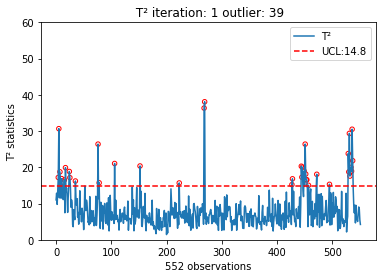

In [154]:
# T square charts
input_T=[X_pca]
#UCL=chi2.isf(alpha,len(X_pca[0,:])) 
UCL=14.86 # Cynthia A. Lowry, William H. Woodall, Charles W. Champ, &amp; Steven E. Rigdon, 1992
for i in range(1,2):
    buffer=mT_square(np.asarray(input_T[i-1]))
    plotData(buffer,UCL," T\u00b2 "+"iteration: "+str(i),tag=True,filename="t_test")
    input_T.append(removeOutlier(input_T[i-1],buffer,UCL)) 

In [112]:
#final_res=removeOutlier(input_T[-1],UCL)
for i in range(len(input_T[-1][0,:])):
               print(jarque_bera(input_T[-1][:,i])[1])

0.28953584990261305
0.0521662633030926
0.15710188012770754
0.014375995951774856
0.0006730620436615764
0.07038890647271234
0.16954705115678514
0.5167671898803207


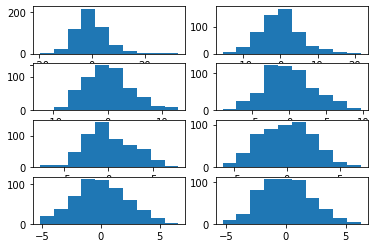

In [113]:
for i in range(len(input_T[-1][1,:])):
    nrow=math.ceil(len(input_T[-1][1,:])/2)
    ncol=2
    plt.subplot(nrow,ncol,i+1)
    plt.hist(X_pca[:,i],label='PC'+str(i+1))
plt.show()

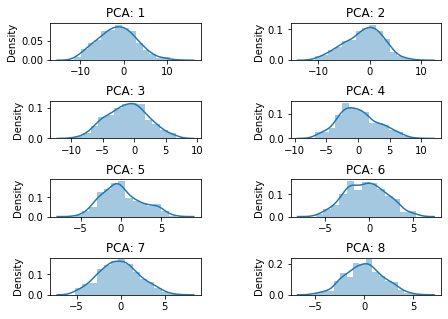

In [116]:
# check whether each row of data follows normal distribution 
fig,ax = plt.subplots(figsize=(7,5))
plt.subplots_adjust(wspace=0.6,hspace=1.1,)
for i in range(len(input_T[-1][1,:])):
    nrow=math.ceil(len(input_T[-1][1,:])/2)
    ncol=2
    plt.subplot(nrow,ncol,i+1)
    sns.distplot(input_T[-1][:,i],label='PC'+str(i+1))
    plt.title("PCA: {}".format(i+1))
plt.show()
plt.savefig("_images/after_tsquare.png")

In [118]:
input_T[-1].shape

(420, 8)

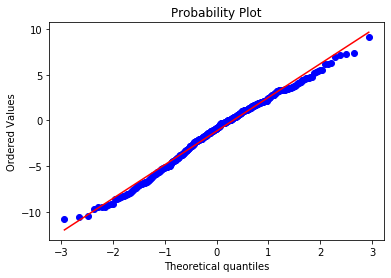

In [121]:
res = probplot(input_T[-1][:,1],plot=plt)

In [87]:
for i in range(input_T[-1].shape[1]):
               print(jarque_bera(input_T[-1][:,i])[1])

0.27203893281913905
0.05132560003759323
0.14995309821810232
0.014141634226054856
0.0005573123465163476
0.073971632050845
0.15880593901657758
0.5039970941899654


###### mCUSUM chart (K=1)

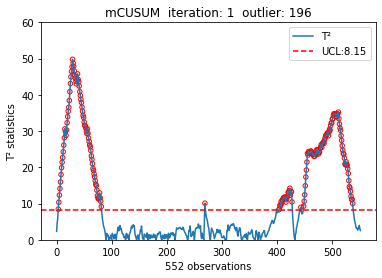

In [155]:
# mCUSUM
input_T_1=[X_pca]
UCL= 8.15
# Cynthia A. Lowry, William H. Woodall, Charles W. Champ, &amp; Steven E. Rigdon, 1992
k=1.0 # statistical distance
for i in range(1,2):
    buffer=mCUSUM(np.asarray(input_T_1[i-1]),k)
    plotData(buffer,UCL,"mCUSUM "+" iteration: "+str(i)+" ",tag=True,filename="t_test_cu")
    input_T_1.append(removeOutlier(input_T_1[i-1],buffer,UCL))
     

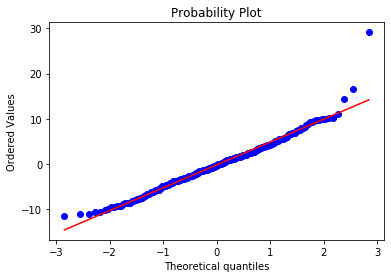

In [125]:
res = probplot(input_T_1[-1][:,0],plot=plt)

In [126]:
for i in range(input_T_1[-1].shape[1]):
               print(jarque_bera(input_T_1[-1][:,i])[1])

0.0
0.04837292793090553
0.2443638673659787
0.008257932151764957
0.02538154490626765
0.06744987981210415
0.12048993841361466
0.3638643939970968


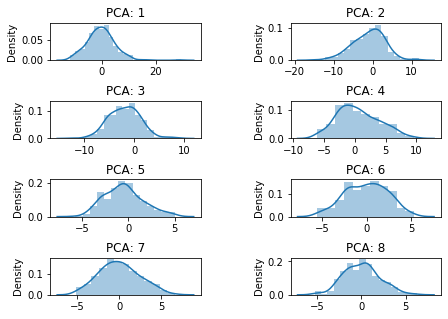

<Figure size 432x288 with 0 Axes>

In [140]:
fig,ax = plt.subplots(figsize=(7,5))
plt.subplots_adjust(wspace=0.6,hspace=1.1,)
for i in range(len(input_T_1[-1][1,:])):
    nrow=math.ceil(len(input_T_1[-1][1,:])/2)
    ncol=2
    plt.subplot(nrow,ncol,i+1)
    sns.distplot(input_T_1[-1][:,i],label='PC'+str(i+1))
    plt.title("PCA: {}".format(i+1))
plt.show()
plt.savefig("_images/after_cusum.png")

###### mEWMA (r=0.1)

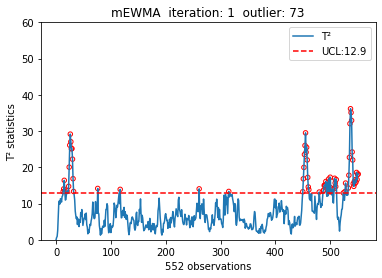

In [157]:
#mEWMA
input_T=[X_pca]
UCL= 12.93 
# Cynthia A. Lowry, William H. Woodall, Charles W. Champ, &amp; Steven E. Rigdon, 1992
r=0.1
for i in range(1,2):
    buffer=mEWMA(np.asarray(input_T[i-1]),r)
    plotData(buffer,UCL,"mEWMA "+" iteration: "+str(i)+" ",tag=True,filename='t_test_ewma')
    input_T.append(removeOutlier(input_T[i-1],buffer,UCL))
     

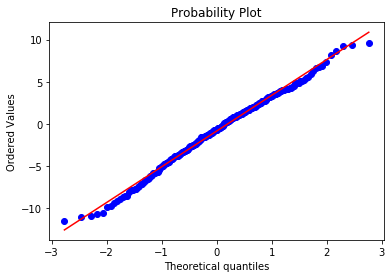

In [134]:
res = probplot(input_T[-1][:,0],plot=plt)

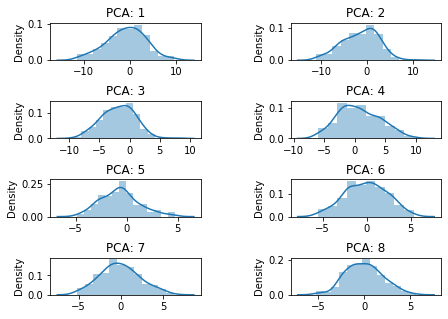

In [135]:
# check whether each row of data follows normal distribution 
fig,ax = plt.subplots(figsize=(7,5))
plt.subplots_adjust(wspace=0.6,hspace=1.1,)
for i in range(len(input_T[-1][1,:])):
    nrow=math.ceil(len(input_T[-1][1,:])/2)
    ncol=2
    plt.subplot(nrow,ncol,i+1)
    sns.distplot(input_T[-1][:,i],label='PC'+str(i+1))
    plt.title("PCA: {}".format(i+1))
plt.show()

In [137]:
for i in range(input_T[-1].shape[1]):
               print(jarque_bera(input_T[-1][:,i])[1])

0.44214247939541673
0.26693267507936413
0.9937110781199645
0.05091917095703258
0.05582923868485268
0.19135895015799254
0.3365813268201192
0.5223490661062404
